In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import QuantileTransformer

# READ DF + NORMALIZE

In [3]:
df = pd.read_csv("CC GENERAL.csv")
df = df.select_dtypes(include=['float', 'int'])
df.dropna(subset=['CREDIT_LIMIT'], inplace=True)
df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].median(), inplace=True)

quantile_trans = QuantileTransformer(n_quantiles=1000, output_distribution='normal')
df_scaled = pd.DataFrame(quantile_trans.fit_transform(df), columns=df.columns)
df_scaled

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,-1.073188,-0.793602,-0.506204,-5.199338,0.016164,-5.199338,-0.407442,-5.199338,-0.119468,-5.199338,-5.199338,-0.457033,-1.566990,-1.188432,-1.011603,-5.199338,5.199338
1,1.039676,-0.574595,-5.199338,-5.199338,-5.199338,1.938433,-5.199338,-5.199338,-5.199338,0.783330,0.692715,-5.199338,0.803958,1.324565,0.897140,0.809168,5.199338
2,0.816719,5.199338,0.435191,0.808952,-5.199338,-5.199338,5.199338,5.199338,-5.199338,-5.199338,-5.199338,0.385726,0.922330,-0.257121,0.506268,-5.199338,5.199338
3,0.507967,-1.046576,0.883400,1.235604,-5.199338,0.233530,-0.625670,0.106841,-5.199338,0.186756,0.167640,-0.625670,0.922330,-5.199338,0.000000,-5.199338,5.199338
4,-0.038491,5.199338,-0.727382,-0.035458,-5.199338,-5.199338,-0.625670,0.106841,-5.199338,-5.199338,-5.199338,-0.625670,-1.132898,-0.187578,-0.202902,-5.199338,5.199338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8944,-1.207085,5.199338,-0.111052,-5.199338,0.399796,-5.199338,5.199338,-5.199338,0.774833,-5.199338,-5.199338,-0.096753,-1.566990,-0.810598,-1.941224,1.107059,-5.199338
8945,-1.367625,5.199338,-0.095492,-5.199338,0.415634,-5.199338,5.199338,-5.199338,0.774833,-5.199338,-5.199338,-0.096753,-1.566990,-0.964361,0.000000,-5.199338,-5.199338
8946,-1.285270,-0.729877,-0.395224,-5.199338,0.123275,-5.199338,0.462610,-5.199338,0.536531,-5.199338,-5.199338,-0.184203,-1.566990,-1.680305,-1.557884,0.844485,-5.199338
8947,-1.506340,-0.729877,-5.199338,-5.199338,-5.199338,0.059854,-5.199338,-5.199338,-5.199338,0.523537,0.387078,-5.199338,-2.325972,-1.812999,-1.866535,0.844485,-5.199338


# Robust Trimmed K Means


In [4]:
import sys
sys.path.append("../RTKM")
from RTKM import * 
from AccuracyMeasures import *
from ClusteringMethods import *

#generate data RTKM untuk comply dengan func silhouette score
def generate_data_RTKM(dataframe, k, percent_outliers, num_members):
    dataframe_np_transposed = dataframe.to_numpy().T

    RTKM_data = RTKM(dataframe_np_transposed)
    RTKM_data.perform_clustering(k=k, percent_outliers = percent_outliers, max_iter = 100, num_members = num_members)
    print(k, percent_outliers, num_members)
    
    #pred clusters return cluster id for data index, pred outliers return outlier index
    pred_clusters, pred_outliers = RTKM_data.return_clusters()

    #Append dataset sehingga mendapatkan id
    cluster_id_RTKM = pd.DataFrame(pred_clusters, columns=['cluster_id'])
    RTKM_result = pd.merge(df_scaled, cluster_id_RTKM, left_index=True, right_index=True)

    # Create a mask for the indices in the DataFrame that need to be modified
    mask = np.isin(RTKM_result.index, pred_outliers)

    # Use np.where to conditionally replace values in cluster_id
    RTKM_result['cluster_id'] = np.where(mask, RTKM_result['cluster_id'].astype(str) + '-out', RTKM_result['cluster_id'])
    all_data = RTKM_result

    # Use boolean indexing to filter out rows based on indices_to_remove
    filtered_data = RTKM_result[~RTKM_result.index.isin(pred_outliers)]
    
    return filtered_data, all_data

# TEST RTKM ALGORITHM with K = 7 and n_percentage = 10

7 0.1 2


c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (5) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (5) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **

<Figure size 800x800 with 0 Axes>

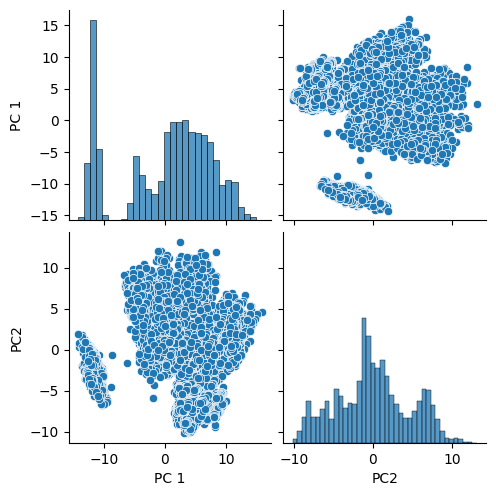

<Figure size 800x800 with 0 Axes>

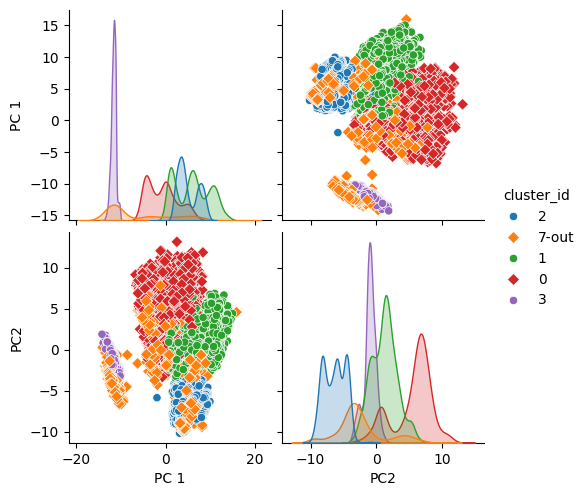

<Figure size 800x800 with 0 Axes>

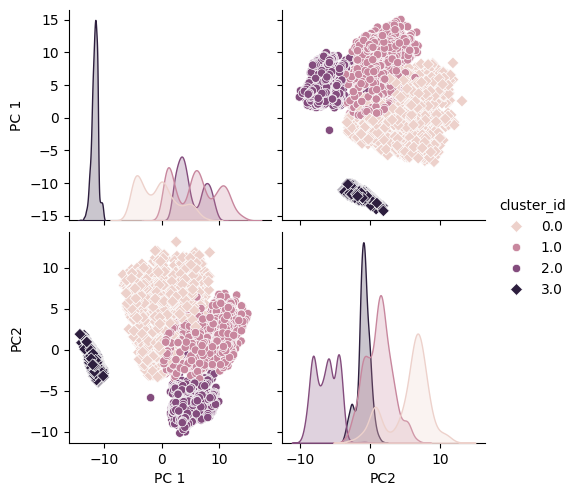

In [5]:
# TEST VISUALIZATION
from sklearn.decomposition import PCA
import seaborn as sns 
from sklearn.metrics import silhouette_score

# PCA variable input
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(df_pca, columns=['PC 1', 'PC2'])
plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca)

# GET inliers (RTKM_result_filtered) and optimal cluster (RTKM_result)
RTKM_result_filtered, RTKM_result = generate_data_RTKM(df_scaled, 7, 0.10, 2)

#PAIR PLOT with OUTLIERS
df_pca['cluster_id'] = RTKM_result.loc[:, RTKM_result.columns.isin(['cluster_id'])]

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca, hue='cluster_id', markers=["o", "D"])

#PAIR PLOT without OUTLIERS
df_pca['cluster_id'] = RTKM_result_filtered.loc[:, RTKM_result_filtered.columns.isin(['cluster_id'])]

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca, hue='cluster_id', markers=["o", "D"])

In [6]:
#FIND SILHOUETTE SCORE
score = silhouette_score(RTKM_result_filtered.drop(['cluster_id'], axis=1), RTKM_result_filtered['cluster_id'])

print(score)

0.35890212021717854


## OPTIMAL PERCENTAGE

In [10]:
from sklearn.metrics import silhouette_score

# Function find optimal RTKM cluster
def find_optimal_RTKM(df, n_cluster):
    best_score = -1
    best_percent = 0
    best_cluster = None
    best_all = None

    for percent in range(5, 35, 5):
        print("PERCENT:", percent)

        # Jalankan RTKM dengan parameter tertentu
        retry_count = 0
        max_retries = 5  # Tentukan jumlah maksimum percobaan

        while retry_count < max_retries:
            inliers, all_data = generate_data_RTKM(df, n_cluster, percent / 100, 2)
            inliers_no_id = inliers.drop(['cluster_id'], axis=1)

            print(inliers.shape)

            # Skip invalid data
            if inliers["cluster_id"].nunique() == 1:
                print("Invalid data, retrying...")
                retry_count += 1
                continue

            # Hitung skor siluet
            score = silhouette_score(inliers_no_id, inliers['cluster_id'])
            print("Score:", score)

            if inliers["cluster_id"].nunique() != n_cluster:
                print("NOTE THAT THE CENTROID DOES NOT MATCH K VALUE")

            # Perbarui parameter terbaik jika skor lebih tinggi
            if score > best_score:
                best_score = score
                best_percent = percent
                best_cluster = inliers
                best_all = all_data

            break  # Keluar dari loop retry jika data valid
    
    print("====================================================")
    print("Best Silhouette Score:", best_score)
    print("Best Percent:", best_percent)

    return best_cluster, best_all

optimal_inlier, optimal_cluster = find_optimal_RTKM(df_scaled, 7)

PERCENT: 5
7 0.05 2
(8502, 18)
Score: 0.22793696826948182
NOTE THAT THE CENTROID DOES NOT MATCH K VALUE
PERCENT: 10
7 0.1 2
(8055, 18)
Score: 0.2700558457279028
NOTE THAT THE CENTROID DOES NOT MATCH K VALUE
PERCENT: 15
Iteration 100
PALM reached maximum number of iterations
7 0.15 2
(7607, 18)
Score: 0.2980936240097838
NOTE THAT THE CENTROID DOES NOT MATCH K VALUE
PERCENT: 20
Iteration 100
PALM reached maximum number of iterations
7 0.2 2
(7159, 18)
Score: 0.30416082627657554
NOTE THAT THE CENTROID DOES NOT MATCH K VALUE
PERCENT: 25
7 0.25 2
(6712, 18)
Score: 0.3873045185595798
NOTE THAT THE CENTROID DOES NOT MATCH K VALUE
PERCENT: 30
Iteration 100
PALM reached maximum number of iterations
7 0.3 2
(6263, 18)
Score: 0.3823472876476129
NOTE THAT THE CENTROID DOES NOT MATCH K VALUE
Best Silhouette Score: 0.3873045185595798
Best Percent: 25


c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (5) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (5) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **kwargs)
c:\Users\jptri\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: 
The markers list has fewer values (2) than needed (4) and will cycle, which may produce an uninterpretable plot.
  func(x=x, y=y, **

<Figure size 800x800 with 0 Axes>

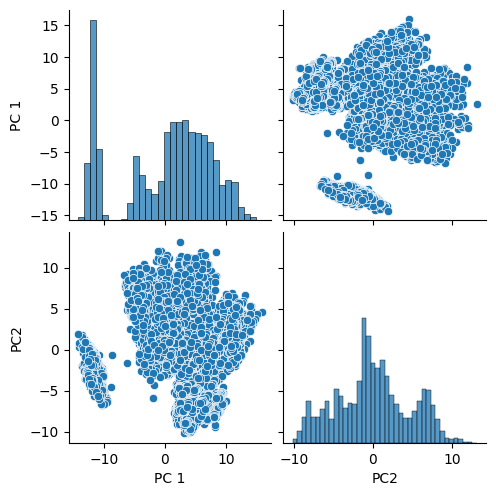

<Figure size 800x800 with 0 Axes>

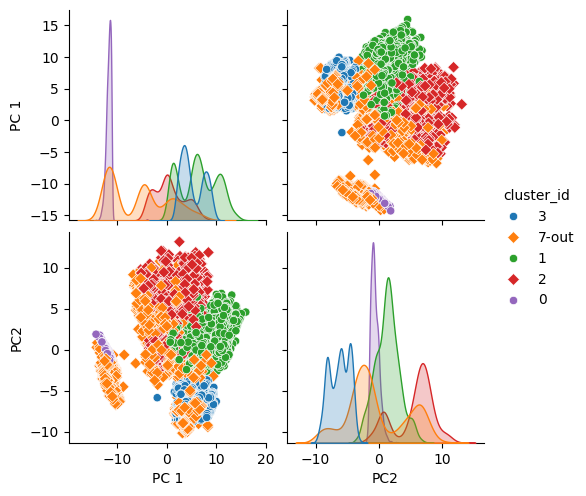

<Figure size 800x800 with 0 Axes>

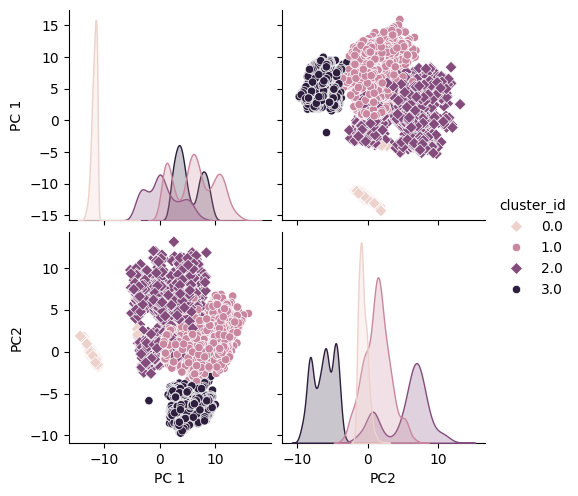

In [12]:
# OPTIMAL VISUALIZATION
from sklearn.decomposition import PCA
import seaborn as sns 

pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(df_pca, columns=['PC 1', 'PC2'])
plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca)

#PAIR PLOT OPTIMAL with OUTLIERS
df_pca['cluster_id'] = optimal_cluster.loc[:, optimal_cluster.columns.isin(['cluster_id'])]

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca, hue='cluster_id', markers=["o", "D"])

#PAIR PLOT OPTIMAL without OUTLIERS
df_pca['cluster_id'] = optimal_inlier.loc[:, optimal_inlier.columns.isin(['cluster_id'])]

plt.figure(figsize=(8,8))
sns.pairplot(data=df_pca, hue='cluster_id', markers=["o", "D"])